In [54]:
# add src to the sys path of this notebook
import sys
import pathlib
sys.path.append(str(pathlib.Path().absolute().parent / "src"))

from load_data import load_data, list_logs, load_labels
from preprocess_data import preprocess_logs, get_label_timeseries
from models.helpers import create_model_params
from models.buckling_model import BucklingModel
from models.double_slope_model import DoubleSlopeModel
import config as config
import numpy as np
import os
from datetime import datetime
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
heads_keep = ["timestamp [s]", "Force sensor voltage [V]"]
heads_rename = ["timestamps", "force_sensor_v"]
f_s = 1000
fss = 568.5
log_names = list_logs(config.PAPER_EXPERIMENT_DATA_FOLDER)
# discard logs 7, 158, 174, errors ? 
log_names.drop([7, 158, 174], inplace=True, errors='ignore')
log_names.reset_index(drop=True, inplace=True)
logs = load_data(log_names, heads_keep, heads_rename, fss)
print(f"Loaded {len(logs)} logs from paper experiments.")

Loaded 205 logs from paper experiments.


In [36]:
log_names.head()

,path,path_markers,datetime,clot_index,direction,stiffness,pressure,clot_presence
0,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:38:36,1,Forward,NaN,NaN,With
1,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:40:03,1,Backward,NaN,NaN,With
2,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:53:54,2,Forward,NaN,NaN,With
3,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 15:55:28,2,Backward,NaN,NaN,With
4,/home/boesch/TREX-Semester-Project/data/raw/Pa...,/home/boesch/TREX-Semester-Project/data/raw/Pa...,2022-06-30 16:04:04,3,Forward,NaN,NaN,With


In [4]:
print(f"Found {sum(log_names['direction'] == 'Backward')} logs with direction Backwards and {sum(log_names['direction'] == 'Forward')} logs with direction Forwards.")

Found 103 logs with direction Backwards and 102 logs with direction Forwards.


In [62]:
labels = load_labels(log_names)
labels.head()

,Start,End
0,10.3,28.0
1,26.6,9.3
2,10.7,25.9
3,23.6,9.4
4,10.3,25.3


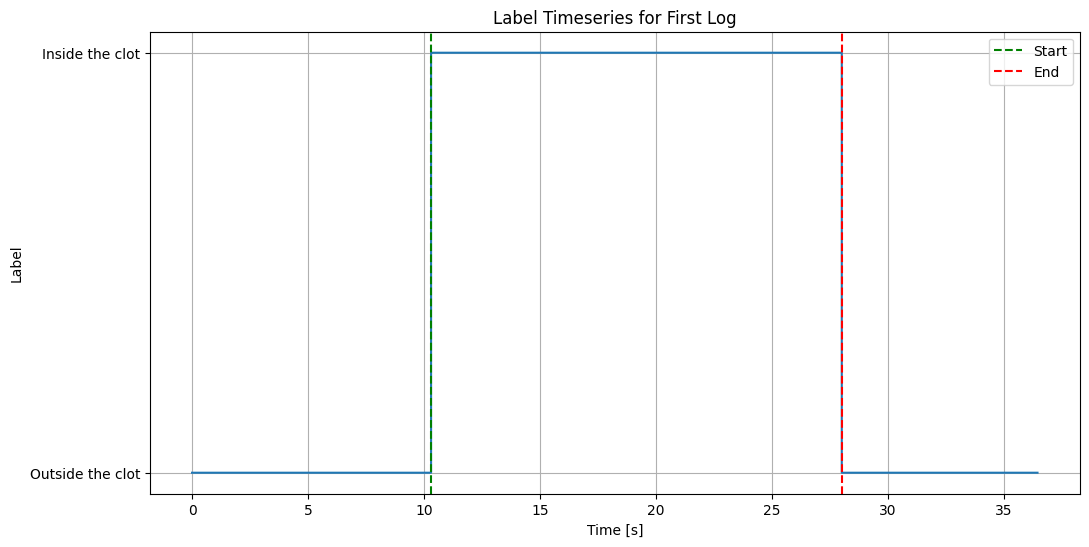

In [63]:
label_timeseries = get_label_timeseries(labels, logs)
# plot the first label timeseries
plt.figure(figsize=(12, 6))
plt.plot(label_timeseries[0]['timestamps'], label_timeseries[0]['in_clot'], drawstyle='steps-post')
# add vertical line at start and end labels 
plt.axvline(x=labels.iloc[0]['Start'], color='g', linestyle='--', label='Start')
plt.axvline(x=labels.iloc[0]['End'], color='r', linestyle='--', label='End')
plt.xlabel('Time [s]')
plt.ylabel('Label')
# make y ticks 0 and 1
plt.yticks([0, 1], ['Outside the clot', 'Inside the clot'])
plt.title('Label Timeseries for First Log')
plt.grid()
plt.legend()
plt.show()

In [64]:
logs_fit = log_names.copy()
data_fit = logs.copy()
data_fit_plot = logs.copy()

preprocess_logs(logs_fit, data_fit, data_fit_plot)

205it [00:01, 200.62it/s]

Preprocessing time: 1.024 s


# Visualize the Data

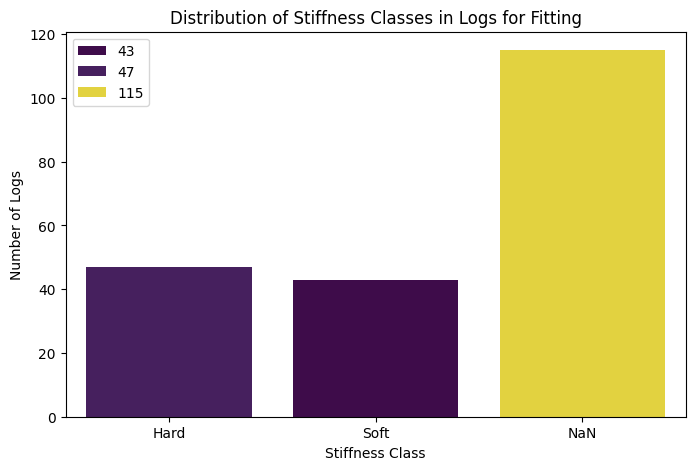

In [6]:
# visualize the distribution of stiffness classes in logs_fit
stiffness_counts = logs_fit['stiffness'].value_counts(dropna=False).sort_index()
# Replace NaN index with a readable label
labels = ['NaN' if pd.isna(x) else x for x in stiffness_counts.index]
plt.figure(figsize=(8, 5))
sns.barplot(x=labels, y=stiffness_counts.values, hue=stiffness_counts.values, palette="viridis", dodge=False)
plt.xlabel('Stiffness Class')
plt.ylabel('Number of Logs')
plt.title('Distribution of Stiffness Classes in Logs for Fitting')
plt.show()


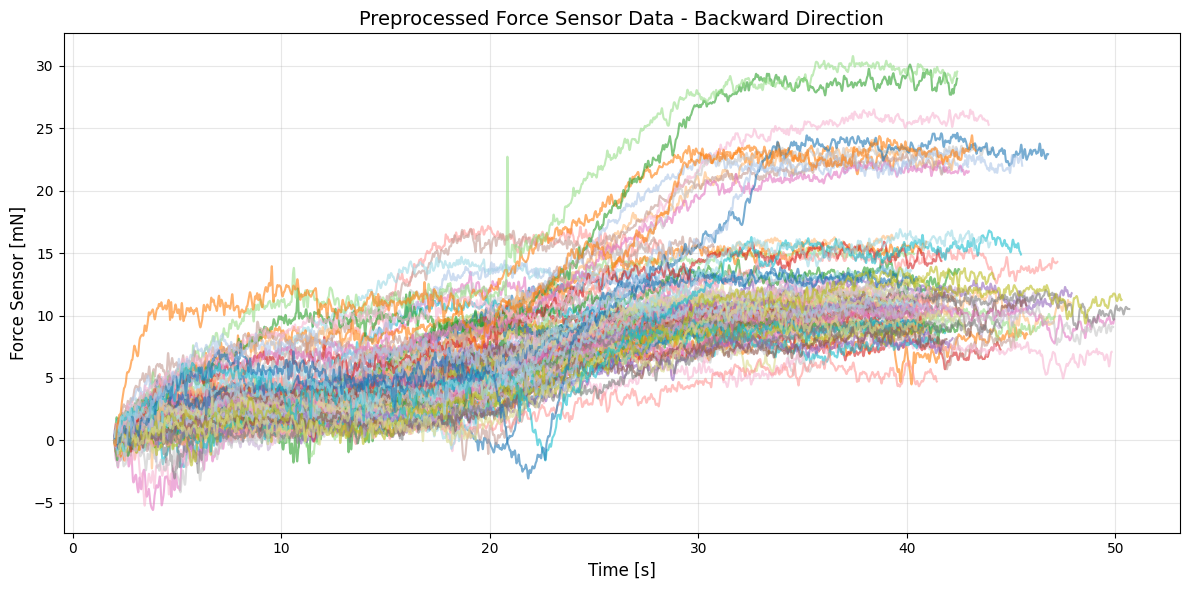

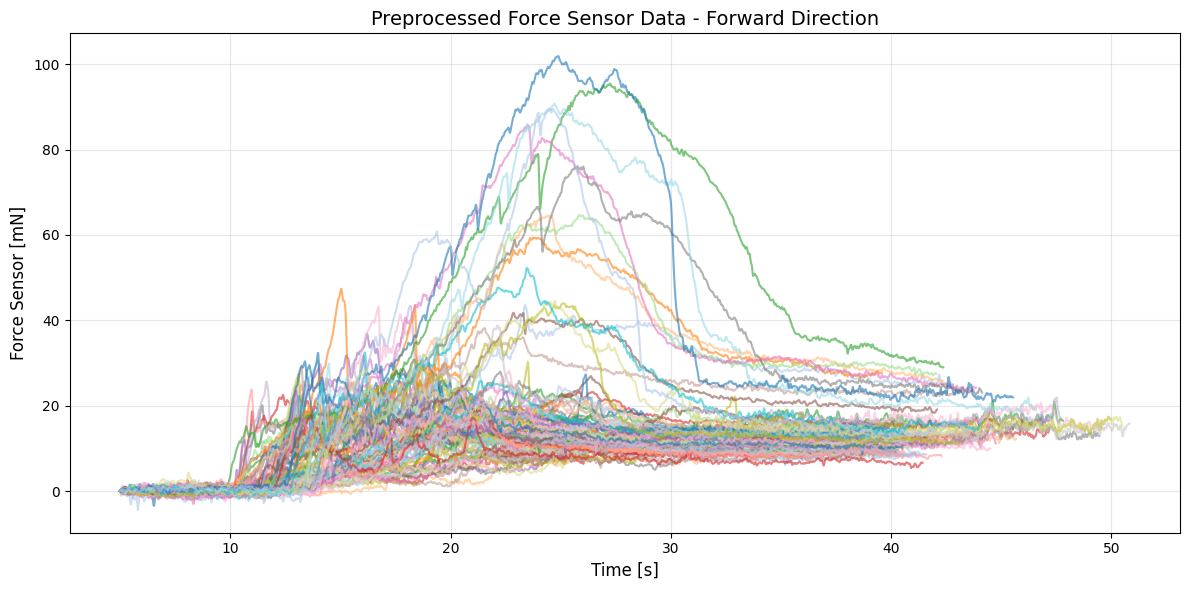

In [7]:


# Combine all curves into a single DataFrame for easier plotting
plot_data = []
for i, df in enumerate(data_fit_plot):
    df_plot = df.copy()
    df_plot['log_index'] = i
    df_plot['direction'] = logs_fit.loc[i, 'direction']
    df_plot['stiffness'] = logs_fit.loc[i, 'stiffness']
    plot_data.append(df_plot)
plot_df = pd.concat(plot_data, ignore_index=True)


for direction in ['Backward', 'Forward']:
    plt.figure(figsize=(12, 6))
    # Filter by direction
    dir_df = plot_df[plot_df['direction'] == direction]
    
    # Plot using sns.lineplot with alpha blending
    sns.lineplot(
        data=dir_df,
        x='timestamps',
        y='force_sensor_mN',
        hue='log_index',        # Different color per log
        palette='tab20',        # Color palette
        alpha=0.6,            # Transparency for overlapping curves
        legend=False            # Avoid huge legends
    )
    
    plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Force Sensor [mN]', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

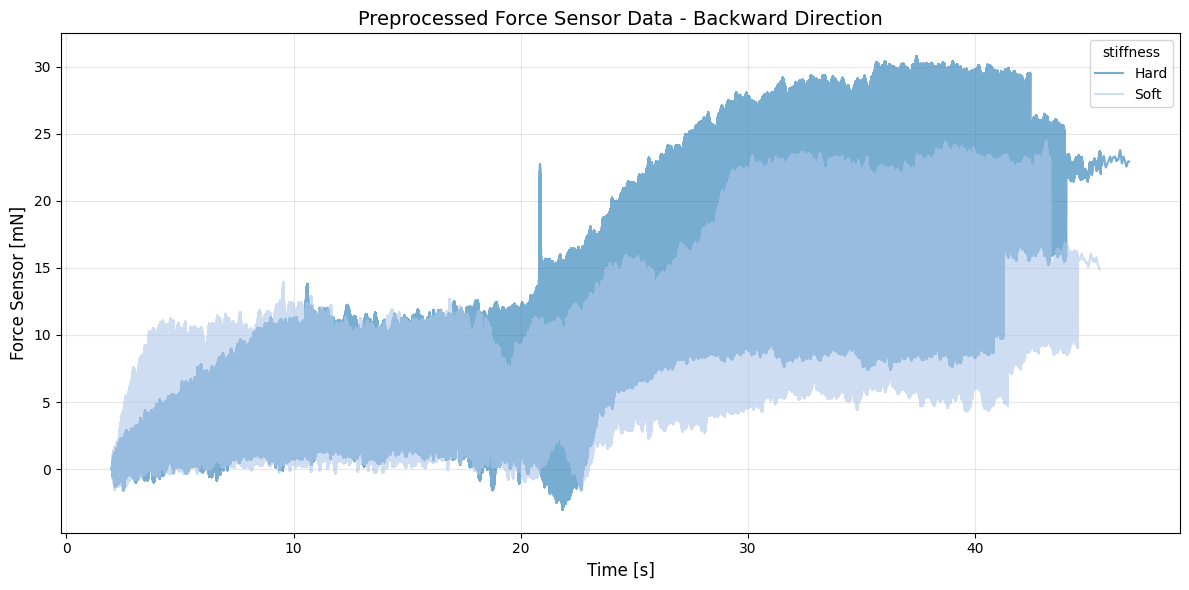

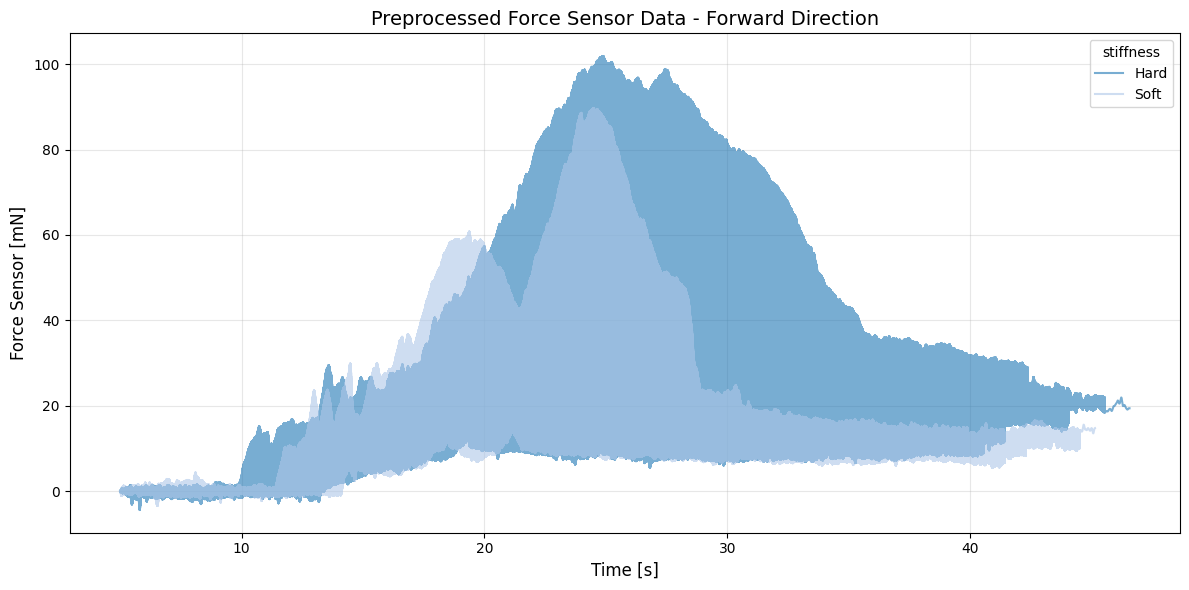

In [8]:
for direction in ['Backward', 'Forward']:
    plt.figure(figsize=(12, 6))
    # Filter by direction
    dir_df = plot_df[plot_df['direction'] == direction]
    
    # Plot using sns.lineplot with alpha blending
    sns.lineplot(
        data=dir_df,
        x='timestamps',
        y='force_sensor_mN',
        hue='stiffness',        # Different color per log
        palette='tab20',        # Color palette
        alpha=0.6,            # Transparency for overlapping curves
        estimator=None
    )
    
    plt.title(f'Preprocessed Force Sensor Data - {direction} Direction', fontsize=14)
    plt.xlabel('Time [s]', fontsize=12)
    plt.ylabel('Force Sensor [mN]', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


# Models

## Buckling

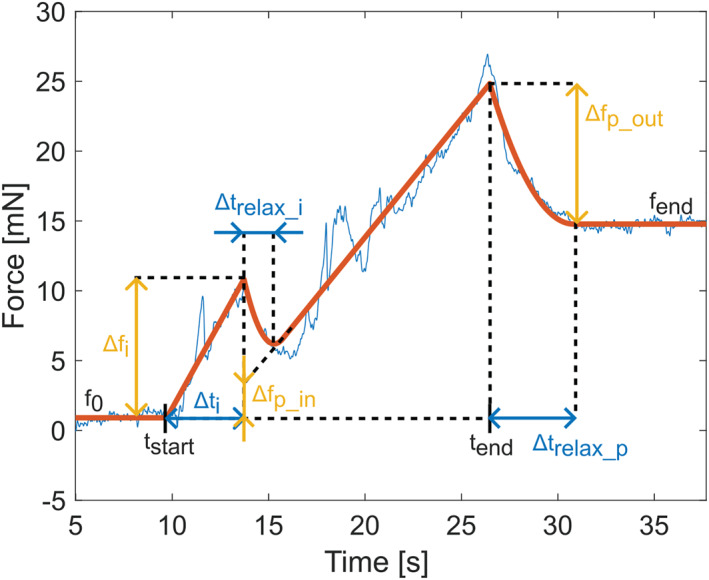

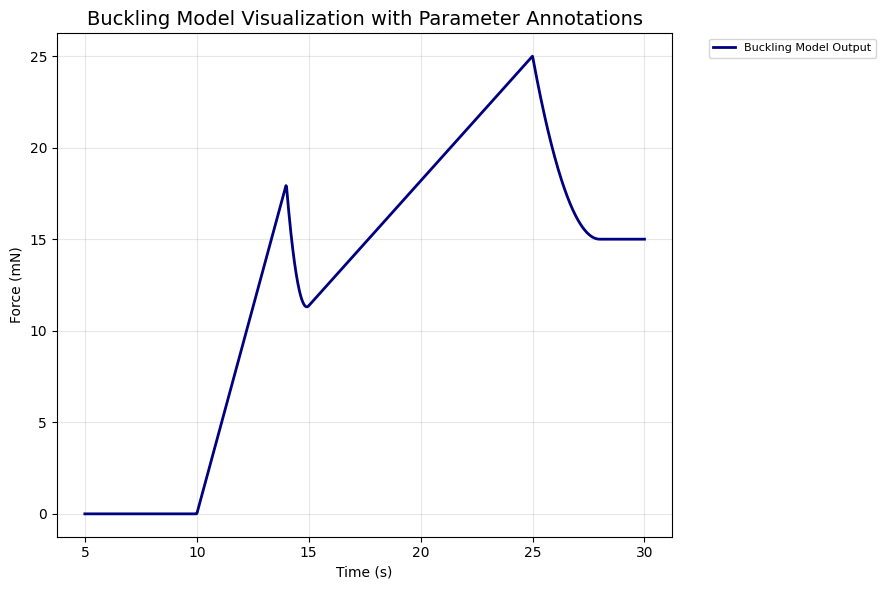

In [9]:
model_params = create_model_params()
xdata = [df["timestamps"].values for df in data_fit]
ydata = [df["force_sensor_mN"].values for df in data_fit] 
model_bk = BucklingModel(model_params, xdata, ydata)
x = np.linspace(5, 30, 1000)
params = (
    10, 25, 0, 15,   # x_start, x_end, y_start, y_end
    10, 10,           # f_pun_rise, f_pun_fall
    4, 8, 1,         # dx_rise, df_rise, k_rise
    1, 3             # dx_pun, dx_fall
)
y = model_bk.model_fun(x, params)
# Plot
plt.figure(figsize=(9, 6))
plt.plot(x, y, label='Buckling Model Output', color='navy', linewidth=2)

plt.title("Buckling Model Visualization with Parameter Annotations", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Force (mN)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()


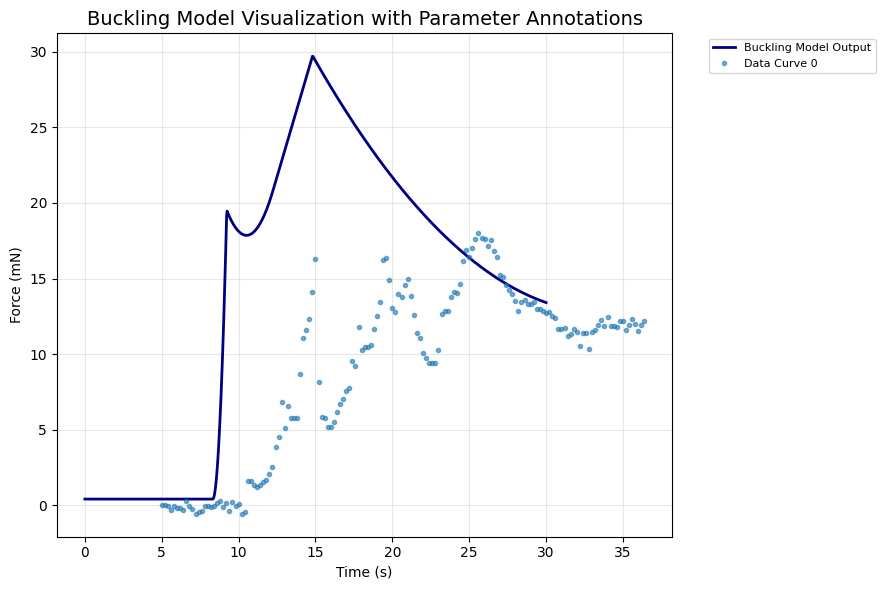

In [ ]:
found_params = (
    8.32205, 14.81225, 0.41775, 12.73864,   # x_start, x_end, y_start, y_end
    10.00768, 16.98367, 0.9067, 9.07795,   # f_pun_fall, f_pun_rise, dx_rise, df_rise
    1.94737, 3.01458, 18.95114  # k_rise, dx_fall, dx_pun
)
x = np.linspace(0, 30, 1000)

y = model_bk.model_fun(x, found_params)
# Plot
plt.figure(figsize=(9, 6))
plt.plot(x, y, label='Buckling Model Output', color='navy', linewidth=2)
plt.plot(xdata[0], ydata[0], 'o', label='Data Curve 0', markersize=3, alpha=0.6)
plt.title("Buckling Model Visualization with Parameter Annotations", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Force (mN)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()

## Double Slope

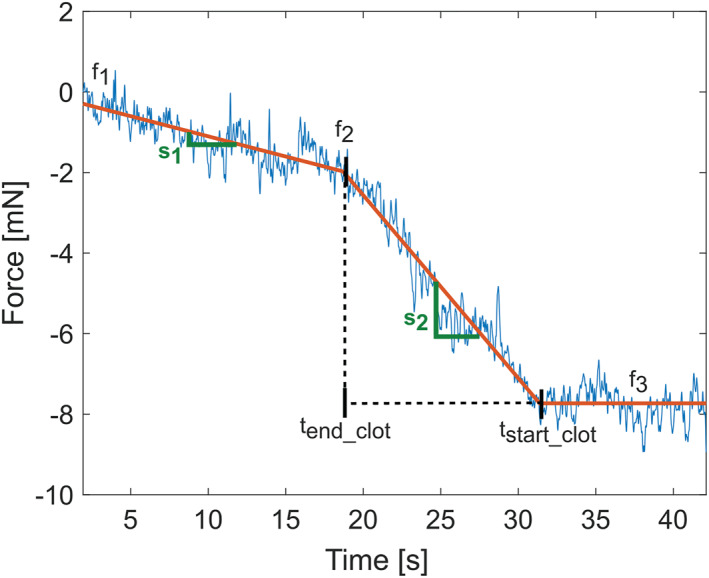

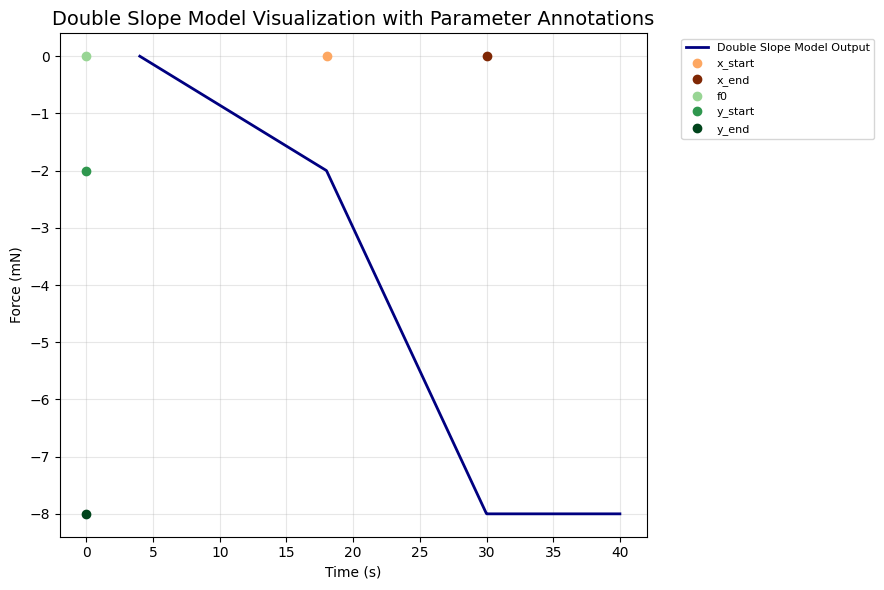

In [32]:
model_ds = DoubleSlopeModel(model_params, xdata, ydata)

x = np.linspace(4, 40, 1000)
params = (
    18, 30,  # x_start, x_end
    0,       # f0
    -2, -8   # y_start, y_end
)
param_names = ["x_start", "x_end", "f0", "y_start", "y_end"]

# Compute model output
y = model_ds.model_fun(x, params)

# Plot model curve
plt.figure(figsize=(9, 6))
plt.plot(x, y, label='Double Slope Model Output', color='navy', linewidth=2)


colors_x = plt.cm.Oranges(np.linspace(0.4, 1, 2))  # 2 shades of orange
colors_y = plt.cm.Greens(np.linspace(0.4, 1, 3))   # 3 shades of green

# Plot x markers individually
for xi, name, c in zip(params[0:2], param_names[0:2], colors_x):
    plt.plot(xi, 0, 'o', color=c, label=name)

# Plot y markers individually
for yi, name, c in zip(params[2:], param_names[2:], colors_y):
    plt.plot(0, yi, 'o', color=c, label=name)

plt.title("Double Slope Model Visualization with Parameter Annotations", fontsize=14)
plt.xlabel("Time (s)")
plt.ylabel("Force (mN)")
plt.grid(alpha=0.3)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
plt.tight_layout()
plt.show()
